In [104]:
import pickle as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [105]:
def jaccard_distance(x, y):
    return 1 - len(set(x).intersection(y)) / len(set(x).union(y))

def sort_files(path):
    base, dataset_name, model_name, eps = path.split(sep="/")
    files = []
    for file in os.listdir(path):
        if file.endswith(".pkl"):
            files.append(file)

    LEN_PREFIX = len(model_name)+1
    LEN_SUFFIX = len(".pkl")
    timestamps = [filename[LEN_PREFIX:-LEN_SUFFIX] for filename in files]
    sorted_timestamps = sorted(timestamps)
    sorted_files = [model_name + "-" + timestamp + ".pkl" for timestamp in sorted_timestamps]

    return sorted_files

def _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=None):
    cut = int(len(item_popularity) * 0.8)
    tail_items = set(item_popularity.sort_values(ascending=True).iloc[:cut].index.tolist())

    recall, ndcg, arp, aft = [], [], [], []
    for uid, recs in recommendation_list.items():
        if impacted_users is not None:
            if uid not in impacted_users:
                continue

        recall.append(len(groundtruth.loc[int(uid)].intersection(recs)) / len(groundtruth.loc[int(uid)]))

        dcg = 0.0
        idcg = 0.0
        for pos in range(1, len(recs)+1):
            item_at_i = recs[pos-1]
            rel_i = item_at_i in groundtruth.loc[int(uid)]
            dcg += rel_i / np.log2(pos + 1)
            idcg += 1 / np.log2(pos + 1)
        ndcg.append(dcg / idcg)

        arp.append(np.mean([item_popularity.loc[item_id] for item_id in recs]))

        aft.append(len(tail_items.intersection(recs)) / len(recs))


    return np.mean(recall), np.mean(ndcg), np.mean(arp), np.mean(aft)


def _analyze_recommendations(dirpath, item_popularity, groundtruth, impacted_users=None):
    files = sort_files(dirpath)
    recalls, ndcgs, arps, afts = [], [], [], []
    #for file in os.listdir(dirpath):
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth, impacted_users=impacted_users[idx])
        else:
            recall, ndcg, arp, aft = _compute_metrics(recommendation_list, item_popularity, groundtruth)
        recalls.append(recall)
        ndcgs.append(ndcg)
        arps.append(arp)
        afts.append(aft)

    return np.nanmean(recalls), np.nanmean(ndcgs), np.nanmean(arps), np.nanmean(afts)

def _get_impacted_users(dirpath_nodp, dirpath_dp):
    files_nodp = sort_files(dirpath_nodp)
    files_dp = sort_files(dirpath_dp)

    impacted_users, frac_impacted_users, avg_dist = [], [], []
    for file_nodp, file_dp in zip(files_nodp, files_dp):
        with open(dirpath_nodp + "/" + file_nodp, "rb") as f:
            recommendation_list_nodp = pl.load(f)

        with open(dirpath_dp + "/" + file_dp, "rb") as f:
            recommendation_list_dp = pl.load(f)

        impacted_users_f, dist_f = [], []
        for uid, recs_dp in recommendation_list_dp.items():
            recs_nodp = recommendation_list_nodp[uid]

            dist = jaccard_distance(recs_nodp, recs_dp)
            if dist > 0:
                impacted_users_f.append(uid)
                dist_f.append(dist)

        frac_impacted_users.append(len(impacted_users_f) / len(recommendation_list_dp))
        impacted_users.append(impacted_users_f)
        dist_f = dist_f if len(dist_f) > 0 else 0
        avg_dist.append(np.mean(np.nanmean(dist_f)))
    return impacted_users, np.mean(frac_impacted_users), np.mean(avg_dist)




In [106]:
def analyze(dataset_name, model_name, groundtruth, item_popularity):
    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth)
    recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = results_nodp
    print("=== %s %s ===" % (dataset_name, model_name))
    print("No DP -> %.2f (recall), %.2f (ndcg), %.2f (arp), %.2f (aft)" % results_nodp)

    delta_recall, delta_ndcg, delta_arp, delta_aft = [], [], [], []
    percentage_impacted_users, average_jaccard_distance = [], []
    for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]:
        users, frac_impacted, jacc = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        results_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=users)
        recall_eps, ndcg_eps, arp_eps, aft_eps = results_eps

        delta_recall.append(100 * (recall_eps - recall_nodp) / recall_nodp)
        delta_ndcg.append(100 * (ndcg_eps - ndcg_nodp) / ndcg_nodp)
        delta_arp.append(100 * (arp_eps - arp_nodp) / arp_nodp)
        delta_aft.append(100 * (aft_eps - aft_nodp) / aft_nodp)

        percentage_impacted_users.append(100 * frac_impacted)
        average_jaccard_distance.append(jacc)

        print("eps: %f -> %.2f%% (recall), %.2f%% (ndcg), %.2f%% (arp), %.2f%% (aft), %.2f (No. Users), %.2f (Jacc)" % (
            eps, delta_recall[-1], delta_ndcg[-1], delta_arp[-1], delta_aft[-1], percentage_impacted_users[-1], average_jaccard_distance[-1]))
    print()
    return delta_recall, delta_ndcg, delta_arp, delta_aft, percentage_impacted_users, average_jaccard_distance

In [128]:
dataset_name = "LFM-3k"

test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

In [129]:
delta_recall, delta_ndcg, delta_arp, delta_aft = dict(), dict(), dict(), dict()
no_users, jacc_dist = dict(), dict()

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="LFM-3k", model_name="BPR", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["BPR"] = recall
delta_ndcg["BPR"] = ndcg
delta_arp["BPR"] = arp
delta_aft["BPR"] = aft
no_users["BPR"] = impacted_users
jacc_dist["BPR"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="LFM-3k", model_name="NeuMF", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["NeuMF"] = recall
delta_ndcg["NeuMF"] = ndcg
delta_arp["NeuMF"] = arp
delta_aft["NeuMF"] = aft
no_users["NeuMF"] = impacted_users
jacc_dist["NeuMF"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="LFM-3k", model_name="LightGCN", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["LightGCN"] = recall
delta_ndcg["LightGCN"] = ndcg
delta_arp["LightGCN"] = arp
delta_aft["LightGCN"] = aft
no_users["LightGCN"] = impacted_users
jacc_dist["LightGCN"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="LFM-3k", model_name="MultiVAE", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["MultiVAE"] = recall
delta_ndcg["MultiVAE"] = ndcg
delta_arp["MultiVAE"] = arp
delta_aft["MultiVAE"] = aft
no_users["MultiVAE"] = impacted_users
jacc_dist["MultiVAE"] = jacc

recall, ndcg, arp, aft, impacted_users, jacc = analyze(dataset_name="LFM-3k", model_name="Pop", groundtruth=groundtruth, item_popularity=item_popularity)
delta_recall["Pop"] = recall
delta_ndcg["Pop"] = ndcg
delta_arp["Pop"] = arp
delta_aft["Pop"] = aft
no_users["Pop"] = impacted_users
jacc_dist["Pop"] = jacc

=== LFM-3k BPR ===
No DP -> 0.06 (recall), 0.03 (ndcg), 0.06 (arp), 0.08 (aft)
eps: 10.000000 -> -0.18% (recall), -3.02% (ndcg), -7.57% (arp), 16.03% (aft), 99.47 (No. Users), 0.61 (Jacc)
eps: 5.000000 -> -2.54% (recall), -3.24% (ndcg), -0.06% (arp), -0.47% (aft), 99.62 (No. Users), 0.60 (Jacc)
eps: 4.000000 -> -1.32% (recall), -2.81% (ndcg), -5.92% (arp), 17.00% (aft), 99.73 (No. Users), 0.61 (Jacc)
eps: 3.000000 -> -4.20% (recall), -6.77% (ndcg), -5.25% (arp), 16.15% (aft), 99.82 (No. Users), 0.62 (Jacc)
eps: 2.000000 -> -11.16% (recall), -13.89% (ndcg), -3.39% (arp), 10.44% (aft), 99.93 (No. Users), 0.64 (Jacc)
eps: 1.000000 -> -23.01% (recall), -26.51% (ndcg), 1.23% (arp), 13.06% (aft), 99.99 (No. Users), 0.69 (Jacc)
eps: 0.500000 -> -39.04% (recall), -39.72% (ndcg), -5.21% (arp), 45.81% (aft), 99.99 (No. Users), 0.73 (Jacc)
eps: 0.100000 -> -52.90% (recall), -55.72% (ndcg), -18.59% (arp), 115.50% (aft), 100.00 (No. Users), 0.80 (Jacc)
eps: 0.050000 -> -54.90% (recall), -58.00% (nd

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'saved/LFM-3k/Pop/nodp'

In [130]:
%matplotlib inline
all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]
#all_eps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4][::-1]

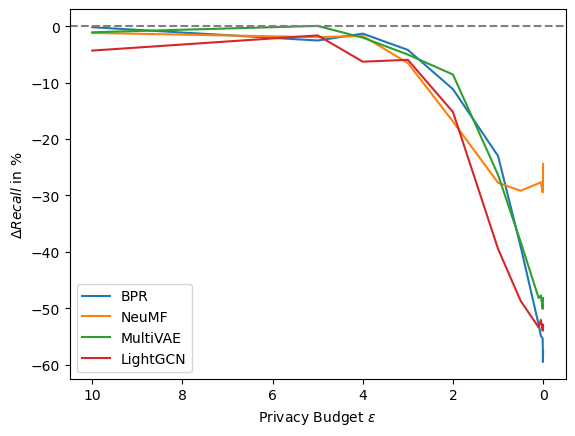

In [136]:
plt.plot(all_eps, delta_recall["BPR"], label="BPR")
plt.plot(all_eps, delta_recall["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_recall["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_recall["LightGCN"], label="LightGCN")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta Recall$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

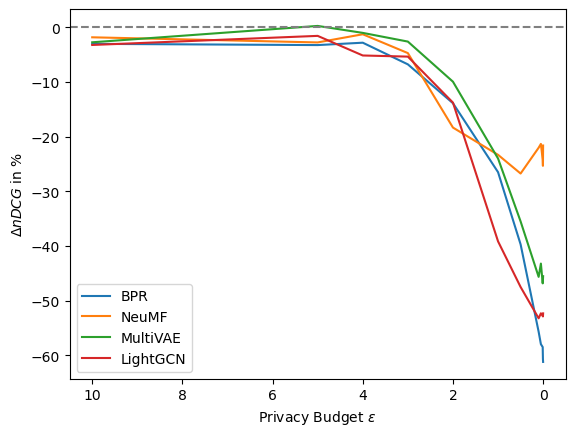

In [137]:
plt.plot(all_eps, delta_ndcg["BPR"], label="BPR")
plt.plot(all_eps, delta_ndcg["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_ndcg["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_ndcg["LightGCN"], label="LightGCN")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta nDCG$ in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

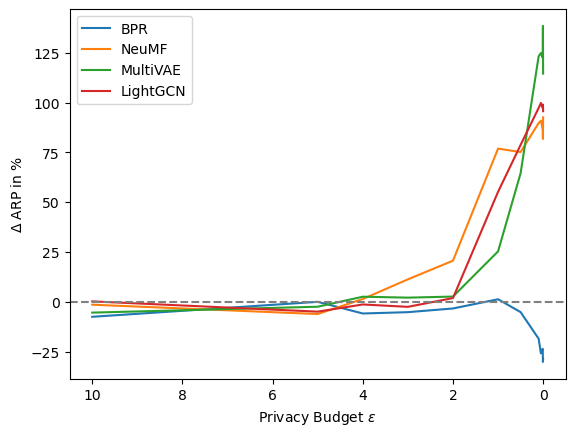

In [138]:
plt.plot(all_eps, delta_arp["BPR"], label="BPR")
plt.plot(all_eps, delta_arp["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_arp["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_arp["LightGCN"], label="LightGCN")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ ARP in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

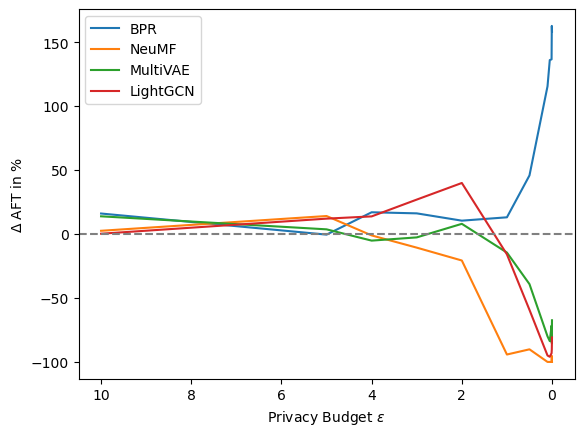

In [139]:
plt.plot(all_eps, delta_aft["BPR"], label="BPR")
plt.plot(all_eps, delta_aft["NeuMF"], label="NeuMF")
plt.plot(all_eps, delta_aft["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, delta_aft["LightGCN"], label="LightGCN")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel(r"$\Delta$ AFT in %")
plt.axhline(y=0, linestyle="dashed", c="gray")
plt.gca().invert_xaxis()
plt.legend()

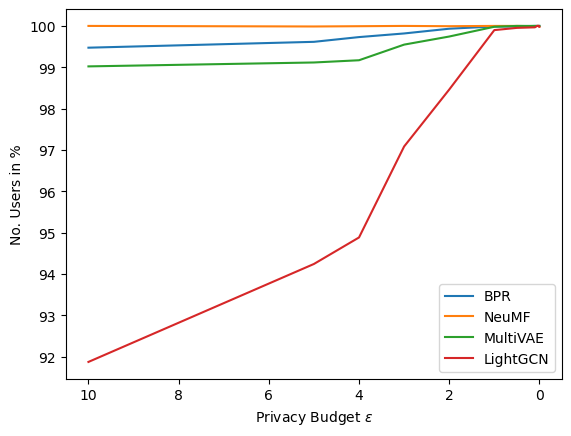

In [140]:
plt.plot(all_eps, no_users["BPR"], label="BPR")
plt.plot(all_eps, no_users["NeuMF"], label="NeuMF")
plt.plot(all_eps, no_users["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, no_users["LightGCN"], label="LightGCN")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("No. Users in %")
plt.gca().invert_xaxis()
plt.legend()

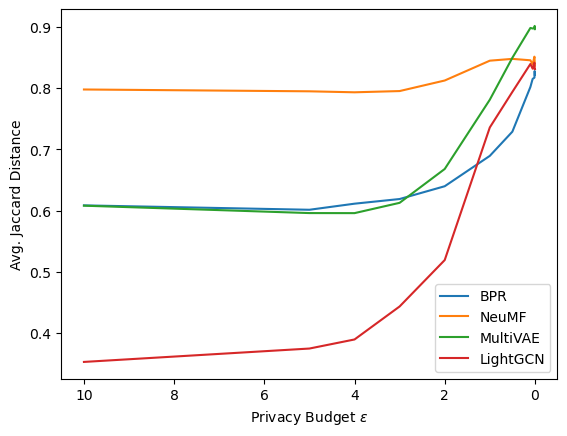

In [141]:
plt.plot(all_eps, jacc_dist["BPR"], label="BPR")
plt.plot(all_eps, jacc_dist["NeuMF"], label="NeuMF")
plt.plot(all_eps, jacc_dist["MultiVAE"], label="MultiVAE")
plt.plot(all_eps, jacc_dist["LightGCN"], label="LightGCN")
plt.xlabel(r"Privacy Budget $\epsilon$")
plt.ylabel("Avg. Jaccard Distance")
plt.gca().invert_xaxis()
plt.legend()

In [70]:
cut = int(len(item_popularity) * 0.2)
head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())

frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
frac_pop_items.name = "frac"

cut = int(len(frac_pop_items) * 0.2)
low_users = frac_pop_items.sort_values().head(cut).index.tolist()
high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

In [96]:
dataset_name = "ml-1m"
model_name = "BPR"
eps = 0.001
dir = "saved/" + dataset_name + "/" + model_name + "/"
users, frac_impacted, jacc = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))

low_and_impacted_str, high_and_impacted_str = [], []
for users_s in users:
    low_and_impacted = set([int(uid) for uid in users_s]).intersection(low_users)
    high_and_impacted = set([int(uid) for uid in users_s]).intersection(high_users)

    low_and_impacted_str.append([str(uid) for uid in low_and_impacted])
    high_and_impacted_str.append([str(uid) for uid in high_and_impacted])

low_results_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=low_and_impacted_str)
high_results_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=high_and_impacted_str)

low_results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=low_and_impacted_str)
high_results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, groundtruth=groundtruth, impacted_users=high_and_impacted_str)

In [97]:
recall_dp, ndcg_dp, arp_dp, aft_dp = low_results_eps
recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = low_results_nodp

(recall_dp - recall_nodp) / recall_nodp, (ndcg_dp - ndcg_nodp) / ndcg_nodp, (arp_dp - arp_nodp) / arp_nodp, (aft_dp - aft_nodp) / aft_nodp

(-0.4130554640915134,
 -0.2158975888086272,
 0.5032505919007046,
 -0.755451358794036)

In [98]:
recall_dp, ndcg_dp, arp_dp, aft_dp = high_results_eps
recall_nodp, ndcg_nodp, arp_nodp, aft_nodp = high_results_nodp

(recall_dp - recall_nodp) / recall_nodp, (ndcg_dp - ndcg_nodp) / ndcg_nodp, (arp_dp - arp_nodp) / arp_nodp, (aft_dp - aft_nodp) / aft_nodp

(-0.17201958162174108,
 -0.1679001152480884,
 0.0454720843947589,
 106.05647275425241)

In [103]:
df.groupby("user_id").size().loc[low_users].mean(), df.groupby("user_id").size().loc[high_users].mean()

(301.737582781457, 69.18708609271523)

# GAP

In [115]:
user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))

In [125]:
def _compute_delta_gap(recommendation_list, item_popularity, user_profile_pop, impacted_users=None):
    gap = []
    for uid, recs in recommendation_list.items():
        if impacted_users is not None:
            if uid not in impacted_users:
                continue

        arp_u = np.mean([item_popularity.loc[item_id] for item_id in recs])
        gap.append((arp_u - user_profile_pop.loc[int(uid)]) / user_profile_pop.loc[int(uid)])


    return np.mean(gap)

def analyze_delta_gap(dirpath, item_popularity, user_profile_popularity, impacted_users=None):
    files = sort_files(dirpath)
    gaps = []
    #for file in os.listdir(dirpath):
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            gap = _compute_delta_gap(recommendation_list, item_popularity, user_profile_popularity, impacted_users=impacted_users[idx])
        else:
            gap = _compute_delta_gap(recommendation_list, item_popularity, user_profile_popularity)
        gaps.append(gap)

    return 100 * np.nanmean(gaps)

In [126]:
dir = "saved/" + dataset_name + "/" + model_name + "/"
delta_gap_nodp = analyze_delta_gap(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_pop)
print("=== %s %s ===" % (dataset_name, model_name))
print("No DP -> %.2f%% (delta gap)" % delta_gap_nodp)

delta_recall, delta_ndcg, delta_arp, delta_aft = [], [], [], []
percentage_impacted_users, average_jaccard_distance = [], []
for eps in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10][::-1]:
    users, frac_impacted, jacc = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
    delta_gap_eps = analyze_delta_gap(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, impacted_users=users)
    print("eps: %f -> %.2f%%" % (eps, delta_gap_eps))

=== ml-1m BPR ===
No DP -> 134.18% (delta gap)
eps: 10.000000 -> 108.12%
eps: 5.000000 -> 114.62%
eps: 4.000000 -> 140.87%
eps: 3.000000 -> 155.22%
eps: 2.000000 -> 123.78%
eps: 1.000000 -> 169.33%
eps: 0.500000 -> 168.47%
eps: 0.100000 -> 183.65%
eps: 0.050000 -> 188.12%
eps: 0.010000 -> 185.97%
eps: 0.005000 -> 188.09%
eps: 0.001000 -> 190.13%


In [127]:
190.13 / 134.18

1.4169771948129377